In [1]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
import src.cleaning as clean
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales_data = pd.read_csv('../../data/anon_data.csv')
cleaned_data = clean.clean_data(sales_data)


C:\Users\C\AppData\Local\Temp\ipykernel_16468\2527773558.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('../../data/anon_data.csv')


In [3]:
# Look at customers based on average profit on an order, average quantity bought in an order, and number of orders. 
# Ignore sales_team_name as this is already a grouping that will be corrrelated to the values above, and KMeans does not handle categorical variables easily due to inability to express distance/ difference in strings with a simple number.
# Keeping in returns and refunds as a customer that orders a lot but returns most of it is not the same as a customer that just orders a lot.


In [4]:
grouped_by_customer = cleaned_data.groupby('customer_id')
summed_values = grouped_by_customer[['profit', 'quantity', 'revenue']].sum()
summed_values.columns = ['profit_by_customer', 'quantity_by_customer', 'revenue_by_customer']


In [5]:
# For number of orders, look at only the orders and not the returns as if a return cancels out an order, that order has a profit of 0 and is only one order not two orders as would be counted by sales_order_number
# Could remove the order entirely but is difficult as one return can cover multiple orders.
only_sales_not_returns = cleaned_data.loc[cleaned_data['quantity']> 0, :]
only_sales_not_returns_grouped = only_sales_not_returns.groupby('customer_id')
orders_by_customer = only_sales_not_returns_grouped['sales_order_number'].unique().apply(len)
shipments_by_customer = only_sales_not_returns_grouped['ship_date'].unique().apply(len)

In [6]:
# Add two extra columns to the dataframe
df_with_orders_and_shipments = summed_values.assign(orders_by_customer=orders_by_customer, shipments_by_customer=shipments_by_customer)

In [7]:
# Calculate profit per order for each customer
# These metrics were not used in the end
df_values_per_order = df_with_orders_and_shipments.assign(profit_per_order_by_customer=df_with_orders_and_shipments['profit_by_customer']/df_with_orders_and_shipments['orders_by_customer'],
                                                    quantity_per_order_by_customer=df_with_orders_and_shipments['quantity_by_customer']/df_with_orders_and_shipments['orders_by_customer'])
df_values_per_order


,profit_by_customer,quantity_by_customer,revenue_by_customer,orders_by_customer,shipments_by_customer,profit_per_order_by_customer,quantity_per_order_by_customer
customer_id,,,,,,,
100000003,33.545133,9,615.122944,6.0,6.0,5.590856,1.500000
100000005,26.949896,6,1130.302162,3.0,4.0,8.983299,2.000000
100000015,307.488853,100,4133.652421,4.0,4.0,76.872213,25.000000
100000029,5.171601,1,57.950596,1.0,1.0,5.171601,1.000000
100000034,8033.501578,1259,101406.265144,377.0,158.0,21.309023,3.339523
...,...,...,...,...,...,...,...
100024529,158.742677,2,1037.821840,2.0,2.0,79.371339,1.000000
100024593,84.538360,1,853.128159,1.0,1.0,84.538360,1.000000
100024597,35.292514,7,601.152233,2.0,2.0,17.646257,3.500000


In [8]:
# Specify feature columns to use
feature_columns = ['profit_by_customer', 'quantity_by_customer']

In [9]:
# Drop NaNs
feature_dataframe = df_values_per_order[feature_columns]
feature_dataframe = feature_dataframe.dropna(axis=0, how='any')
df_values_per_order.shape[0] - feature_dataframe.shape[0]

0

### KMeans Clustering is sensitive to outlier so outliers need to be remove

In [10]:
upper_quartiles = feature_dataframe.quantile(0.75)
lower_quartiles = feature_dataframe.quantile(0.25)
iqr = upper_quartiles - lower_quartiles
iqr

profit_by_customer      1239.95261
quantity_by_customer     149.00000
dtype: float64

In [11]:
upper_bounds = (upper_quartiles + 1.5*iqr)
lower_bounds = (lower_quartiles - 1.5*iqr)
upper_bounds

profit_by_customer      3150.258855
quantity_by_customer     378.500000
dtype: float64

In [12]:
outliers = ((feature_dataframe > upper_bounds) | (feature_dataframe < lower_bounds)).any(axis=1)
outliers.sum()

632

In [13]:
# That's a lot of outliers, what if we just removed top and bottom 5% as these are more likely to be fake orders
quantile_outliers = ((feature_dataframe > feature_dataframe.quantile(0.95)) | (feature_dataframe < feature_dataframe.quantile(0.05))).any(axis=1)
quantile_outliers.sum()
# This also removed negatives, using outlier only removes a few negatives

380

In [14]:
removed_outliers = feature_dataframe[~quantile_outliers]
removed_outliers

,profit_by_customer,quantity_by_customer
customer_id,,
100000003,33.545133,9
100000005,26.949896,6
100000015,307.488853,100
100000029,5.171601,1
100000034,8033.501578,1259
...,...,...
100024529,158.742677,2
100024593,84.538360,1
100024597,35.292514,7


### Notes
Given this large number of outliers, consider k-medoids.
Using KMeans but removed upper and lower 5% of data. Having explored the data, these are likely to be outlier cause by returns or low revenue and negative profit resulting in questionable data points. 

<Axes: xlabel='profit_by_customer', ylabel='quantity_by_customer'>

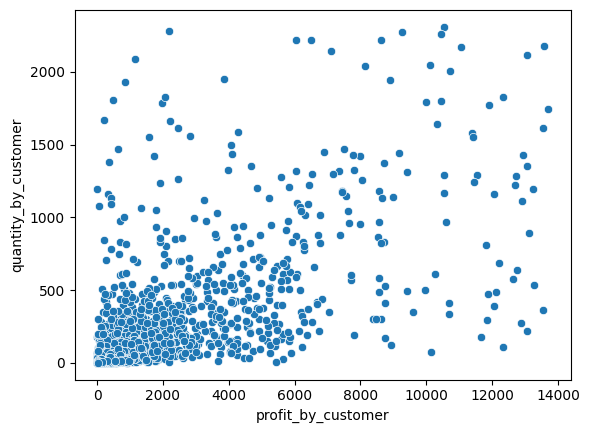

In [15]:
sns.scatterplot(removed_outliers, x=feature_columns[0], y=feature_columns[1])

### Notes
Does appear to be any clear cut clusters, one main cluster around (50, 25) but everything else is sparse

In [16]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(removed_outliers)
scaled_data = pd.DataFrame(scaled_data, columns=feature_columns)

In [17]:
# Use elbow method to find optimal k
results = []
silhouettes = []
k_range = list(range(2, 40))
for k in k_range:
    k_mean_clusterer = KMeans(n_clusters=k, random_state=26)
    k_mean_clusterer.fit(scaled_data)
    silhouettes.append(silhouette_score(scaled_data, k_mean_clusterer.labels_))
    results.append(k_mean_clusterer.inertia_)

d:\Interviews\Exertis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Interviews\Exertis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Interviews\Exertis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Interviews\Exertis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Interviews\Exertis\venv\lib\site-packages\skl

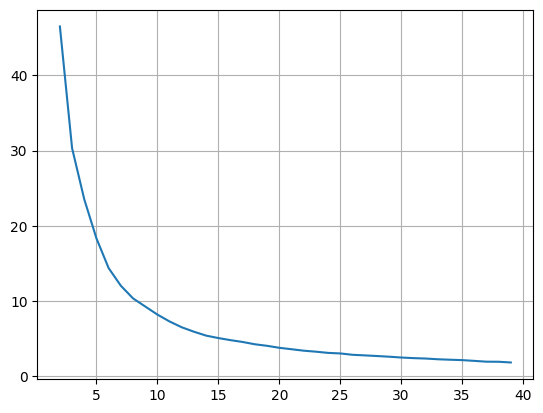

In [18]:
plt.plot(k_range, results)
plt.grid(True)

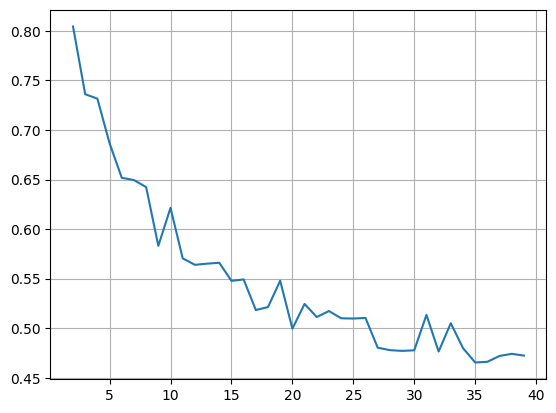

In [19]:
plt.plot(k_range, silhouettes)
plt.grid(True)

# Final Clustering

In [20]:
# Choose a k of 5 given the results and intial cluster plot

In [21]:
k_mean_clusterer = KMeans(n_clusters=5, random_state=26, n_init=100)
k_mean_clusterer.fit_predict(scaled_data)
results_data = removed_outliers.assign(cluster=k_mean_clusterer.labels_)

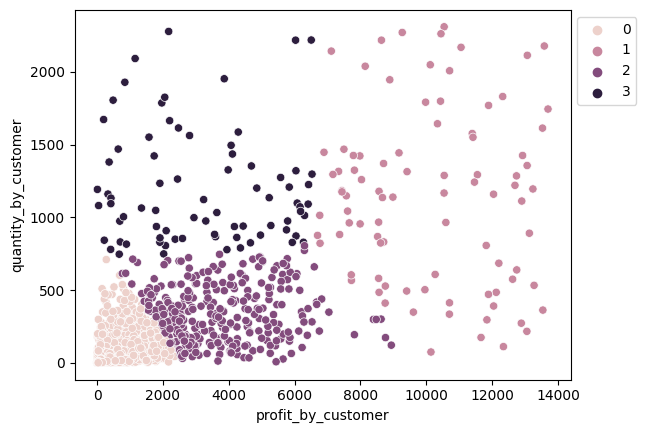

In [22]:
plot = sns.scatterplot(data=results_data, x=feature_columns[0], y=feature_columns[1], hue='cluster')
plot.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [23]:
# For curiosity:
# Set feature_columns=['profit_per_order_by_customer', 'quantity_per_order_by_customer', 'orders_by_customer'] and run all above to use this plot

In [24]:
import matplotlib.colors
sns.set_style ("darkgrid")
plot_mean = 3
min_num = 30
x = results_data['quantity_per_order_by_customer']
y = results_data['profit_per_order_by_customer']
z = results_data['orders_by_customer']
colours = results_data['cluster']
colors = ['red','green','blue','purple', 'black', 'cornflowerblue', 'lime', 'darkorange', 'sienna', 'teal', 'aqua', 'deeppink', 'gold']
figure = plt.figure(figsize = (10, 10))
seaborn_plot = figure.add_subplot(111, projection='3d')

seaborn_plot.scatter(x, y, z, c=colours, cmap=matplotlib.colors.ListedColormap(colors))
seaborn_plot.set_xlabel ('quantity_per_order')
seaborn_plot.set_ylabel ('profit_per_order')
seaborn_plot.set_zlabel ('number_of_orders')
plt.show ()

KeyError: 'quantity_per_order_by_customer'